# Library Load

In [1]:
import os
import io
import re
import base64
import json
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional

from langchain.agents import initialize_agent, Tool, AgentType
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import BaseMessage
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA

from IPython.display import display, HTML

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

# Config

In [3]:
## PATH ##
ROOT = os.path.join(os.path.dirname(os.getcwd()), 'AgenticRAG')
FILE_PATH = os.path.join(ROOT, "database", "manual")

if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}") # 파일이 없을 경우 에러 발생
    
# vector store path
VECTORSTORE_PATH = os.path.join(ROOT, "database/vectorstore")
if not os.path.exists(VECTORSTORE_PATH):
    os.makedirs(VECTORSTORE_PATH)
    
# embedding model path
EMBEDDING_MODEL_DIR_PATH = os.path.join(ROOT, "database/embedding_model/")
if not os.path.exists(EMBEDDING_MODEL_DIR_PATH):
    os.makedirs(EMBEDDING_MODEL_DIR_PATH)

# fdc database path
FDC_DB_PATH = os.path.join(ROOT, "data")
if not os.path.exists(FDC_DB_PATH):
    os.makedirs(FDC_DB_PATH)

# Data Load

In [4]:
anomaly_data = pd.read_csv(os.path.join(FDC_DB_PATH, "anomaly_history_data.csv"))
anomaly_data['start_time'] = pd.to_datetime(anomaly_data['start_time'])
anomaly_data['end_time'] = pd.to_datetime(anomaly_data['end_time'])
anomaly_data = anomaly_data[['start_time', 'end_time', 'cmk', 'threshold', 'pattern_name']]
anomaly_data.head()

,start_time,end_time,cmk,threshold,pattern_name
0,2025-04-21 00:05:00,2025-04-21 00:05:59,1.776238,2.8,noise
1,2025-04-21 00:06:00,2025-04-21 00:06:59,2.059372,2.8,noise
2,2025-04-21 00:18:00,2025-04-21 00:18:59,2.761220,2.8,noise
3,2025-04-21 00:31:00,2025-04-21 00:31:59,2.079087,2.8,noise
4,2025-04-21 00:32:00,2025-04-21 00:32:59,2.624173,2.8,noise


In [5]:
raw_data = pd.read_csv(os.path.join(FDC_DB_PATH, "raw_data.csv"))
raw_data.head()

,TIME,SLOT,STEP_ID,Header_pressure_Act,Header_pressure_Set,state,class,cmk,section_class,error
0,2025-04-21 00:00:00,2.0,1.0,0.998119,0.999861,1,0,NaN,NaN,0.000000
1,2025-04-21 00:00:01,2.0,1.0,0.805644,0.399578,1,0,NaN,NaN,0.000000
2,2025-04-21 00:00:02,2.0,1.0,0.407863,0.399578,1,0,NaN,NaN,0.000003
3,2025-04-21 00:00:03,2.0,2.0,0.675494,0.999861,1,0,NaN,NaN,0.000000
4,2025-04-21 00:00:04,2.0,2.0,1.008201,0.999861,1,0,NaN,NaN,0.000003


# Tool

## Tool - 조치이력(Retrieval)

In [6]:
from langchain_community.document_loaders import Docx2txtLoader

loader = Docx2txtLoader("./database/manual/조치이력보고서.docx")
docs = loader.load()

for doc in docs:
    print(doc.page_content)

보고서



문서 번호: RPT-20250421-001

작성 일자: 2025-04-21

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 ‘noise’ 이고 threshold 와 cmk 값의 차가 0.5 미만입니다.

이에 따라 정상 오차 범위로 판단하여 설비 멈춤 없이 공정 진행하였고, 모니터링을 강화 조치를 취했습니다.



오류 2:

감지한 이상 패턴이 'noise'이며, 연속 2회 이상 발생했습니다.

이에 따라 공정 변수를 점검하고 주요 센서를 캘리브레이션 진행 후 정상화를 확인하는 조치를 진행하였습니다.




보고서



문서 번호: RPT-20250422-001

작성 일자: 2025-04-22

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 'drift'로, cmk 값이 0.2 이하입니다.

이에 따라 주요 부품 마모 확인 후 교체를 진행하였으며, 이 후 공정 안정성 재점검을 실시하였습니다.



오류 2:

감지한 이상 패턴이 'drift'이나, cmk가 0.2 이상의 이상이 발생하였습니다.

이에 따라 설비 가동을 유지한 채 해당 구간에 대해 공정 조건 일시 조정 및 경향성을 모니터링 하였습니다. 




보고서



문서 번호: RPT-20250423-001

작성 일자: 2025-04-23

작성자: 김프로



[조치 이력]

오류 1:

감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.

이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다.



오류 2:

감지한 이상 패턴이 'shift'이나, cmk 값이 0.5 이하, 0.4 이상인 이상이 발생하였습니다.

이에 공정 운전은 유지하고, 주기적 측정 강화 및 예비 점검 항목을 추가하였습니다.



오류 3:

감지한 이상 패턴이 ‘shift’로, cmk 값이 0.5 이상인 이상이 발생하였습니다.

이는 공정에 큰 영향을 미치지 않는 이상으로 설비 가동을 유지하였고

In [7]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_core.documents import Document
import re

# 1. 워드 파일 로드
loader = Docx2txtLoader("./database/manual/조치이력보고서.docx")
docs = loader.load()

# 2. 전체 텍스트 합치기
full_text = "\n".join([doc.page_content for doc in docs])

# 3. '보고서' 기준으로 페이지 분할
pages = full_text.split("보고서")
pages = [page.strip() for page in pages if page.strip()]

# 최종 저장할 리스트
final_documents = []

# 4. 각 페이지 처리
for page in pages:
    # 문서 번호, 작성 일자, 작성자 추출
    doc_num_match = re.search(r"문서 번호:\s*(.+)", page)
    date_match = re.search(r"작성 일자:\s*(.+)", page)
    writer_match = re.search(r"작성자:\s*(.+)", page)
    
    doc_num = doc_num_match.group(1).strip() if doc_num_match else ""
    date = date_match.group(1).strip() if date_match else ""
    writer = writer_match.group(1).strip() if writer_match else ""
    
    # '조치 이력' 이후만 잘라서 오류 파싱
    after_history = page.split("[조치 이력]")[-1].strip()
    
    # "오류 1:", "오류 2:" 기준으로 오류 분리
    errors = re.split(r"오류\s*\d+\s*:", after_history)
    errors = [e.strip() for e in errors if e.strip()]
    
    # 오류 번호도 필요하니까 다시 찾자
    error_numbers = re.findall(r"오류\s*(\d+)\s*:", after_history)

    for error_content, error_no in zip(errors, error_numbers):
        document = Document(
            page_content=error_content,
            metadata={
                "문서 번호": doc_num,
                "작성 일자": date,
                "작성자": writer,
                "오류번호": int(error_no)
            }
        )
        final_documents.append(document)

# 5. 결과 확인
for i, doc in enumerate(final_documents):
    print(f"[Document {i+1}]")
    print(doc.metadata)
    print(doc.page_content)
    print("\n")


[Document 1]
{'문서 번호': 'RPT-20250421-001', '작성 일자': '2025-04-21', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 ‘noise’ 이고 threshold 와 cmk 값의 차가 0.5 미만입니다.

이에 따라 정상 오차 범위로 판단하여 설비 멈춤 없이 공정 진행하였고, 모니터링을 강화 조치를 취했습니다.


[Document 2]
{'문서 번호': 'RPT-20250421-001', '작성 일자': '2025-04-21', '작성자': '김프로', '오류번호': 2}
감지한 이상 패턴이 'noise'이며, 연속 2회 이상 발생했습니다.

이에 따라 공정 변수를 점검하고 주요 센서를 캘리브레이션 진행 후 정상화를 확인하는 조치를 진행하였습니다.


[Document 3]
{'문서 번호': 'RPT-20250422-001', '작성 일자': '2025-04-22', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 'drift'로, cmk 값이 0.2 이하입니다.

이에 따라 주요 부품 마모 확인 후 교체를 진행하였으며, 이 후 공정 안정성 재점검을 실시하였습니다.


[Document 4]
{'문서 번호': 'RPT-20250422-001', '작성 일자': '2025-04-22', '작성자': '김프로', '오류번호': 2}
감지한 이상 패턴이 'drift'이나, cmk가 0.2 이상의 이상이 발생하였습니다.

이에 따라 설비 가동을 유지한 채 해당 구간에 대해 공정 조건 일시 조정 및 경향성을 모니터링 하였습니다.


[Document 5]
{'문서 번호': 'RPT-20250423-001', '작성 일자': '2025-04-23', '작성자': '김프로', '오류번호': 1}
감지한 이상 패턴이 'shift'로, cmk 값이 0.4 이하의 이상이 발생하였습니다.

이에 따라 Alignment 오류 가능성 점검 후 로봇으로 보정 작업을 진행하였습니다.


[Document 6]
{

In [8]:
os.environ["TRANSFORMERS_CACHE"] = EMBEDDING_MODEL_DIR_PATH
os.environ["HF_HOME"] = EMBEDDING_MODEL_DIR_PATH

In [9]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(
    model_name = "intfloat/multilingual-e5-large-instruct",
)

vectorstore_report = FAISS.from_documents(
    final_documents,
    embedding_model,
)

retriever1 = vectorstore_report.as_retriever()

c:\Users\kangd\anaconda3\envs\rag\Lib\site-packages\transformers\utils\hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Tool - 이상감지 이력(Retirever)

# Main

## LLM

In [131]:
llm = ChatGoogleGenerativeAI(temperature=0.1, model="gemini-2.0-flash")
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# Latest Date - raw_data.csv 기준
time = pd.to_datetime(raw_data['TIME'])
latest_data_date = time.max().normalize().strftime("%Y-%m-%d")

agent_context = {
    "last_plot_date": None,
    "last_plot_columns": None,
    "last_anomaly_info": None,
}

## Tool - 이상감지 이력(PythonPEPLTool)

In [132]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()


anomaly_code_prompt = PromptTemplate(
    input_variables=["query"],
    template="""
You are a data assistant that writes Python (pandas) code to filter a DataFrame named `anomaly_data`.

Here is the description of the columns in the 'anomaly_history' table:
- `start_time`: datetime when the anomaly event started (format: YYYY-MM-DD HH:MM:SS)
- `end_time`: datetime when the anomaly event ended (format: YYYY-MM-DD HH:MM:SS)
- `cmk`: numeric value indicating the anomaly confidence measure
- `threshold`: numeric value representing the threshold for anomaly detection
- `pattern_name`: string describing the type of pattern detected (e.g., 'noise')

⚠️ Note:
- "에러 패턴" does not mean pattern_name == 'error'. Instead, retrieve all anomalies on the requested date.

Write one line of Python code assigning the result to a variable named `result`.
Only use the `anomaly_data` DataFrame and pandas syntax.
Do NOT include markdown or explanation.

Always assign to variable `result` a DataFrame that includes the columns: ['start_time', 'end_time', 'pattern_name', 'cmk', 'threshold'].

Query: {query}

Python code:
"""
)

anomaly_code_chain = LLMChain(llm=llm, prompt=anomaly_code_prompt)

In [133]:
def execute_anomaly_code(code: str, context: dict = None):
    context = context or {}
    local_vars = {"anomaly_data": anomaly_data, "pd": pd}
    local_vars.update(context)

    print(f"[DEBUG] Available Columns: {anomaly_data.columns}")

    try:
        # 🔧 문자열 전처리 추가
        cleaned_code = re.sub(r"^```(?:python)?\s*|\s*```$", "", code.strip(), flags=re.MULTILINE)
        exec_globals = {}
        exec_locals = local_vars
        exec(cleaned_code, exec_globals, exec_locals)
        return exec_locals["result"]
    except Exception as e:
        return f"[ERROR in exec] {str(e)}"

## Tool - Sensordata 시각화

In [134]:
def plot_sensor_data(columns: List[str], query:str, start_time=None, end_time=None) -> str:
    from IPython.display import Image 
    # Load the data
    df = raw_data.copy()
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    if start_time:
        df = df[df['TIME'] >= pd.to_datetime(start_time)]
    if end_time:
        df = df[df['TIME'] <= pd.to_datetime(end_time)]
       
    fig, ax = plt.subplots(figsize=(12, 4))
    for col in columns:
        ax.plot(df['TIME'], df[col], label=col)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f"Sensor Data: {', '.join(columns)}")
    ax.legend()
    ax.grid()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    return display(Image(data=buf.read()))


# Prompt

## PlotSensorData Prompt

In [135]:
plot_query_prompt = PromptTemplate(
    input_variables=["query", "chat_history", "latest_data_date"],
    template="""
Extract the following information from the user's query and conversation:
1. "columns": One or more of ['Header_pressure_Act', 'Header_pressure_Set', 'cmk', 'error']
2. "date": Extract the date mentioned or implied. 
    - If user says "가장 최근" or "latest", use {latest_data_date}
    - If the user is asking for the most recent *pattern* or *anomaly event*, use the latest date in the data (e.g., anomaly_data['start_time'].max() or {latest_data_date}).
    - If the user is referring to the most recent *plot* or *graph*, use the most recently visualized date based on prior conversation (e.g., last_plot_date).
    - If user says "그 전날" or "전날짜", use the date of the most recent assistant message containing "시각화한 날짜: YYYY-MM-DD" minus 1 day.
    - If user says "그 다음날" or "다음날짜", use the date of the most recent assistant message containing "시각화한 날짜: YYYY-MM-DD" plus 1 day.
    - If user says "그때" or "위 그래프", extract date from most recent assistant message containing "시각화한 날짜: YYYY-MM-DD"

Return JSON:
{{
  "columns": [...],
  "date": "YYYY-MM-DD",
  "message": "..."
}}

Return only valid JSON. Do NOT wrap it in triple backticks or markdown.

Query: {query}
Chat History:
{chat_history}
"""
)


plot_query_chain = LLMChain(llm=llm, prompt=plot_query_prompt)

## QueryAnomalyHistory Prompt

In [136]:
anomaly_query_prompt = PromptTemplate(
    input_variables=["query", "chat_history", "latest_data_date", "last_plot_date", "last_plot_columns"],
    template="""
You are an assistant responsible for rewriting the user's query into a concrete anomaly search question.

Context interpretation rules:
- If the user says "latest" or "가장 최근", use {latest_data_date}.
- If the user is asking for the most recent *pattern* or *anomaly event*, use the latest date in the data (e.g., anomaly_data['start_time'].max() or {latest_data_date}).
- If the user is referring to the most recent *plot* or *graph*, use the most recently visualized date based on prior conversation (e.g., last_plot_date).
- If the user says "the previous day" or "그 전날" or "전날짜", use {last_plot_date} minus 1 day.
- If the user says "the next day" or "그 다음날" or "다음날짜", use {last_plot_date} plus 1 day.
- If the user says "that time", "the graph above", or "그때" or "위 그래프", use the explicitly provided value: {last_plot_date}.

💡 The most recent plot date was: {last_plot_date}
💡 The most recently plotted columns were: {last_plot_columns}

From the user query, extract:
- A specific date
- A specific anomaly type (e.g., error, spike)

Then, rephrase the query into a format like:
"Show me the error pattern that occurred on 2025-04-24."

Only output the final rephrased query as a single string.

Query: {query}
Chat History:
{chat_history}
"""
)
anomaly_query_chain = LLMChain(llm=llm, prompt=anomaly_query_prompt)

In [137]:
# anomaly_query_prompt = PromptTemplate(
#     input_variables=["query", "chat_history", "latest_data_date", "last_plot_date", "last_plot_columns"],
#     template="""
# You are a smart assistant that rewrites vague user queries into precise anomaly search commands.

# You are given:
# - latest_data_date: {latest_data_date}
# - last_plot_date: {last_plot_date}
# - last_plot_columns: {last_plot_columns}

# The chat history may include previous assistant messages like:
# - "시각화한 날짜: YYYY-MM-DD"
# This means a graph was plotted on that date — treat this as a reliable clue for "그때", "위 그래프", or "전날", "다음날".

# --- Examples ---

# User: 위 그래프의 에러 패턴은?
# → Rewritten: "Show me the error pattern that occurred on {last_plot_date}."

# User: 가장 최근 에러 패턴은?
# → Rewritten: "Show me the error pattern that occurred on {latest_data_date}."

# User: 그 전날 어떤 이상이 있었지?
# → Rewritten: "Show me the anomaly pattern that occurred on the day before {last_plot_date}."

# User: 그때 발생한 이상 유형은?
# → Rewritten: "Show me the anomaly pattern that occurred on {last_plot_date}."

# User: cmk가 1.5 이상인 건 뭐야?
# → Rewritten: "Show anomalies where cmk > 1.5."

# --- Now do the same with this query ---

# User: {query}

# Chat History:
# {chat_history}
# """
# )

# anomaly_query_chain = LLMChain(llm=llm, prompt=anomaly_query_prompt)

## RecomendActions Prompt

In [138]:
recommend_query_prompt = PromptTemplate(
    input_variables=["query", "chat_history", "context"],
    template="""
Extract the relevant anomaly pattern name(s) from the query or from the most recent assistant message that provided anomaly information.

If the user says "그때 발생했던 각 이상들에 대한 조치는?", refer to the following structured anomaly result context:
{context}

From this, generate a query such as:
"spike 패턴에 대해 cmk=1.02, threshold=2.8일 때의 조치는?"

Query: 
{query}

Chat History:
{chat_history}
"""
)
recommend_query_chain = LLMChain(llm=llm, prompt=recommend_query_prompt)

# Debug

In [139]:
def get_latest_plot_date_from_memory() -> Optional[str]:
    """
    Memory 에서 '시각화한 날짜: YYYY-MM-DD' 가 포함된 가장 최근 assistant 메시지의 날짜를 추출
    """
    messages = agent.memory.chat_memory.messages
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            match = re.search(r"시각화한 날짜:\s*(\d{4}-\d{2}-\d{2})", msg.content)
            if match:
                return match.group(1)
    return None

def run_plot_tool(parsed_json_str: str):
    try:
        cleaned = re.sub(r"^```(?:json)?\s*|\s*```$", "", parsed_json_str.strip(), flags=re.MULTILINE)
        parsed = json.loads(cleaned)

        date = parsed.get("date")
        columns = parsed.get("columns", [])

        # 🔧 보완: 날짜 누락 시 memory에서 마지막 시각화 날짜를 추출
        if not date:
            date = agent_context.get("last_plot_date") or get_latest_plot_date_from_memory() or latest_data_date

        if not columns:
            return "[ERROR] 시각화할 컬럼 정보가 누락되었습니다."

        agent_context["last_plot_date"] = date
        agent_context["last_plot_columns"] = columns

        start_time = f"{date} 00:00:00"
        end_time = f"{date} 23:59:59"

        img = plot_sensor_data(columns, query="generated by agent", start_time=start_time, end_time=end_time)
        display(img)

        return (
            f"시각화한 날짜: {date}\n"
            f"{date}의 {', '.join(columns)} 그래프를 시각화했습니다.\n"
            f"그래프를 확인했으니, 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요."
    )

    except Exception as e:
        return f"[ERROR] run_plot_tool 실패: {str(e)}"

def run_anomaly_tool(query: str, context: dict = None, chat_history: str = "") -> str:
    try:
        last_plot_date = agent_context.get("last_plot_date")
        last_plot_columns = agent_context.get("last_plot_columns", [])

        if not last_plot_date:
            last_plot_date_match = re.search(
                r"시각화한 날짜: (\d{4}-\d{2}-\d{2})",
                "\n".join([m.content for m in memory.chat_memory.messages])
            )
            if last_plot_date_match:
                last_plot_date = last_plot_date_match.group(1)
                agent_context["last_plot_date"] = last_plot_date

        if not last_plot_date:
            return "[ERROR] 최근에 시각화된 날짜 정보가 없습니다. 먼저 그래프를 그려야 합니다."

        transformed_query = anomaly_query_chain.run({
            "query": query,
            "chat_history": chat_history,
            "latest_data_date": latest_data_date,
            "last_plot_date": last_plot_date,
            "last_plot_columns": ", ".join(last_plot_columns)
        })

        code = anomaly_code_chain.run(transformed_query)
        result_df = execute_anomaly_code(code, context=context)

        if isinstance(result_df, pd.Series):
            return "[ERROR] Series가 아닌 DataFrame이 필요합니다."
        if not isinstance(result_df, pd.DataFrame):
            return "[ERROR] 예상하지 못한 결과 형식입니다."
        if result_df.empty:
            return f"{last_plot_date}에는 이상 패턴이 감지되지 않았습니다."

        result_df = result_df.sort_values("start_time")
        row_as_dict = result_df[["start_time", "end_time", "pattern_name", "cmk", "threshold"]].to_dict(orient="records")

        # 저장
        agent_context["last_anomaly_info"] = row_as_dict
        observation_log = (
            "[아래는 이상 패턴 결과입니다. 요약하지 말고 그대로 출력하십시오.]\n" +
            "\n".join([
                f"start_time: {row['start_time']}, end_time: {row['end_time']}, "
                f"cmk: {float(row['cmk']):.2f}, threshold: {float(row['threshold']):.2f}, pattern_name: {row['pattern_name']}"
                for row in row_as_dict
            ])
        )
        agent_context["last_anomaly_observation_text"] = observation_log

        return observation_log

    except Exception as e:
        return f"[ERROR] run_anomaly_tool 실패: {str(e)}"

# def run_anomaly_tool(query: str, context: dict = None, chat_history: str = "") -> str:
#     try:
#         last_plot_date = agent_context.get("last_plot_date")
#         last_plot_columns = agent_context.get("last_plot_columns", [])

#         if not last_plot_date:
#             # fallback from memory
#             last_plot_date_match = re.search(
#                 r"시각화한 날짜: (\d{4}-\d{2}-\d{2})",
#                 "\n".join([m.content for m in memory.chat_memory.messages])
#             )
#             if last_plot_date_match:
#                 last_plot_date = last_plot_date_match.group(1)
#                 agent_context["last_plot_date"] = last_plot_date

#         if not last_plot_date:
#             return "[ERROR] 최근에 시각화된 날짜 정보가 없습니다. 먼저 그래프를 그려야 합니다."

#         transformed_query = anomaly_query_chain.run({
#             "query": query,
#             "chat_history": chat_history,
#             "latest_data_date": latest_data_date,
#             "last_plot_date": last_plot_date,
#             "last_plot_columns": ", ".join(last_plot_columns)
#         })

#         code = anomaly_code_chain.run(transformed_query)
#         result_df = execute_anomaly_code(code, context=context)

#         if isinstance(result_df, pd.Series):
#             return "[ERROR] Series가 아닌 DataFrame이 필요합니다."

#         if not isinstance(result_df, pd.DataFrame):
#             return "[ERROR] 예상하지 못한 결과 형식입니다."

#         if result_df.empty:
#             return f"{last_plot_date}에는 이상 패턴이 감지되지 않았습니다."
        
#         result_df = result_df.sort_values("start_time")

#         row_as_dict = result_df[["start_time", "end_time", "pattern_name", "cmk", "threshold"]].to_dict(orient="records")
#         agent_context["last_anomaly_info"] = row_as_dict

#         lines = []
#         for row in row_as_dict:
#             line = (
#                 f"start_time: {row.get('start_time', 'N/A')}, "
#                 f"end_time: {row.get('end_time', 'N/A')}, "
#                 f"cmk: {row.get('cmk', 'N/A')}, "
#                 f"threshold: {row.get('threshold', 'N/A')}, "
#                 f"pattern_name: {row.get('pattern_name', 'N/A')}"
#             )
#             lines.append(line)
#         return "\n".join(lines)
    
#     except Exception as e:
#         return f"[ERROR] run_anomaly_tool 실패: {str(e)}"



def run_recommend_tool(query: str, chat_history: str = "") -> str:
    try:
        context_text = agent_context.get("last_anomaly_observation_text", "")
        if not context_text:
            return "[ERROR] anomaly observation 정보가 없습니다. 먼저 이상 탐지를 수행하세요."

        transformed_query = recommend_query_chain.run({
            "query": query,
            "chat_history": chat_history,
            "context": context_text
        })

        retriever_qa = RetrievalQA.from_chain_type(
            llm=llm,
            retriever=retriever1,
            chain_type="stuff",
        )

        response = retriever_qa.invoke(transformed_query)
        if isinstance(response, dict):
            return response.get("result", "").strip()
        return str(response).strip()

    except Exception as e:
        return f"[ERROR] run_recommend_tool 실패: {str(e)}"
    
def resolve_latest_plot_date():
    return (
        agent_context.get("last_plot_date")
        or get_latest_plot_date_from_memory()
        or latest_data_date
    )

In [169]:
def run_recommend_tool_per_item(query: str, chat_history: str = "") -> str:
    rows = agent_context.get("last_anomaly_info", [])

    if not rows:
        return "[ERROR] 이전 anomaly 정보가 없습니다. 먼저 QueryAnomalyHistory를 실행하세요."

    results = []
    for row in rows:
        context_text = (
            f"{row['start_time']} ~ {row['end_time']}: "
            f"패턴={row['pattern_name']}, cmk={row['cmk']}, threshold={row['threshold']}"
        )
        transformed_query = recommend_query_chain.run({
            "query": query,
            "chat_history": chat_history,
            "context": context_text
        })

        retriever_qa = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever1,
        )

        response = retriever_qa.invoke(transformed_query)
        
        # 💡 대응 코드 추가
        if isinstance(response, dict):
            answer = response.get("result", str(response))
        else:
            answer = str(response)

        results.append(f"📌 {context_text}\n➡ {answer.strip()}")

    return "\n\n".join(results)

# Tool List

In [170]:
tools = [
    Tool(
        name="PlotSensorData",
        description="시계열 센서 데이터를 시각화합니다. 예: '가장 최근 error 그래프', '그때의 설정값과 실제값 그래프'. 날짜가 명시되지 않으면 문맥을 통해 추론된 날짜를 사용합니다.",
        func=lambda q: run_plot_tool(plot_query_chain.run({
            "query": q,
            "chat_history": "\n".join([m.content for m in memory.chat_memory.messages]),
            "latest_data_date": resolve_latest_plot_date()
        })),
        return_direct=False,
    ),
    Tool(
        name="QueryAnomalyHistory",
        description=(
            "Retrieve anomaly information from CSV based on past plot date, pattern_name, cmk, or threshold. "
            "For example: 'What was the pattern on the day of the last error graph?' or "
            "'Show anomalies with cmk over 1.5'. This tool transforms the query contextually before execution."
        ),
        func=lambda q: run_anomaly_tool(
            q, 
            context={"anomaly_data": anomaly_data},
            chat_history="\n".join([m.content for m in memory.chat_memory.messages])),
        return_direct=False,
    ),
    Tool(
        name="RecommendActions",
        description="이상 패턴에 대해 적절한 조치를 추천. 이전에 감지된 여러 이상 정보가 있을 경우 각각에 대해 조치 내용을 제공합니다.",
        func=lambda q: run_recommend_tool_per_item(
            query=q,
            chat_history="\n".join([m.content for m in memory.chat_memory.messages])
        )
    )
    # Tool(
    #     name="RecommendActions",
    #     description="이상 패턴에 대해 적절한 조치 방법을 추천합니다. 예: '그때 발생한 이상들에 대한 조치 방법은?'"
    #                 "이전에 검색된 패턴명, CMK, 임계값 정보를 활용해 조치 검색 쿼리를 생성합니다.",
    #     func=lambda q: run_recommend_tool(
    #         query=q,
    #         chat_history="\n".join([m.content for m in memory.chat_memory.messages]),
    #     )
    # )
]

# REACT Agent

In [171]:
# === 5. REACT Agent 초기화 ===
agent = initialize_agent(
    tools=tools,
    llm=llm,
    memory=memory,
    verbose=True,
    agent_type="tool-calling",
    handle_parsing_errors=True,
)



> Entering new AgentExecutor chain...
먼저 2025-04-23의 error 그래프를 표시해야 합니다.
Action: PlotSensorData
Action Input: 2025-04-23 error 그래프

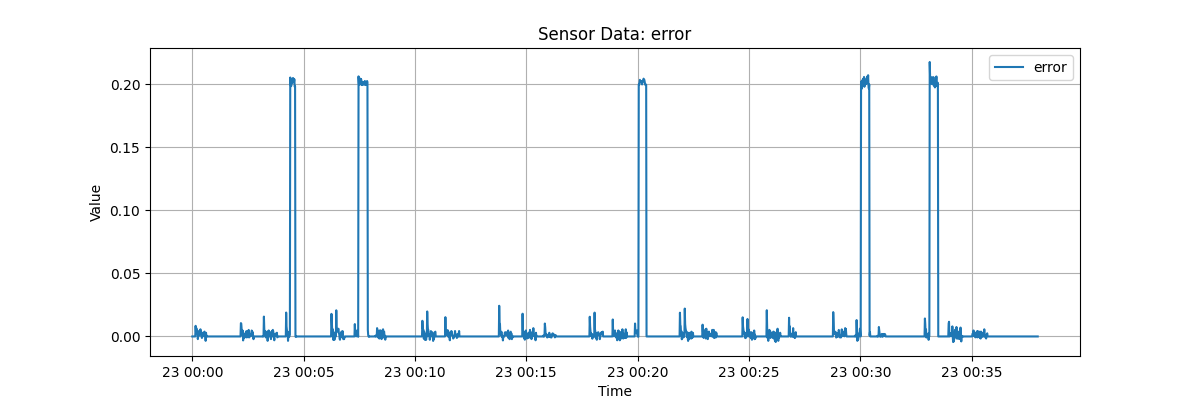

None


Observation: 시각화한 날짜: 2025-04-23
2025-04-23의 error 그래프를 시각화했습니다.
그래프를 확인했으니, 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요.
Thought:Final Answer: 2025-04-23의 error 그래프가 표시되었습니다. 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요.

> Finished chain.


'2025-04-23의 error 그래프가 표시되었습니다. 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요.'

In [172]:
agent.run("2025-04-23의 error 그래프를 보여줘")



> Entering new AgentExecutor chain...
설정값과 실제값 그래프를 요청하셨으므로 PlotSensorData 도구를 사용해야 합니다. 날짜가 명시되어 있으므로 해당 날짜를 Action Input에 포함합니다.
Action: PlotSensorData
Action Input: 2025-04-24의 설정값과 실제값 그래프

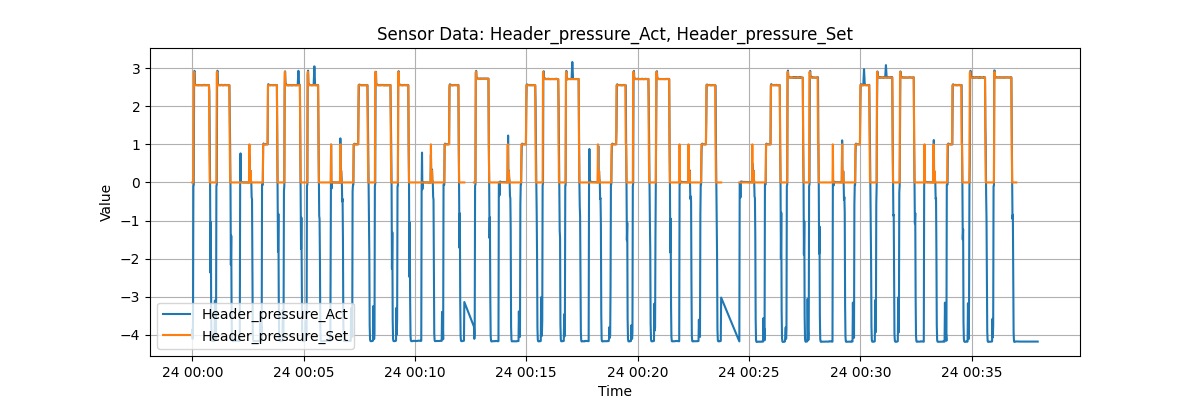

None


Observation: 시각화한 날짜: 2025-04-24
2025-04-24의 Header_pressure_Act, Header_pressure_Set 그래프를 시각화했습니다.
그래프를 확인했으니, 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요.
Thought:Final Answer: 2025-04-24의 Header_pressure_Act, Header_pressure_Set 그래프가 표시되었습니다.

> Finished chain.


'2025-04-24의 Header_pressure_Act, Header_pressure_Set 그래프가 표시되었습니다.'

In [173]:
agent.run("2025-04-24의 설정갑과 실제값의 그래프를 보여줘")



> Entering new AgentExecutor chain...
그래프가 무엇인지 명시되어 있지 않으므로, 먼저 가장 최근 에러 그래프를 표시해야 합니다. 그런 다음 해당 그래프의 에러 패턴을 쿼리할 수 있습니다.
Action: PlotSensorData
Action Input: 가장 최근 error 그래프

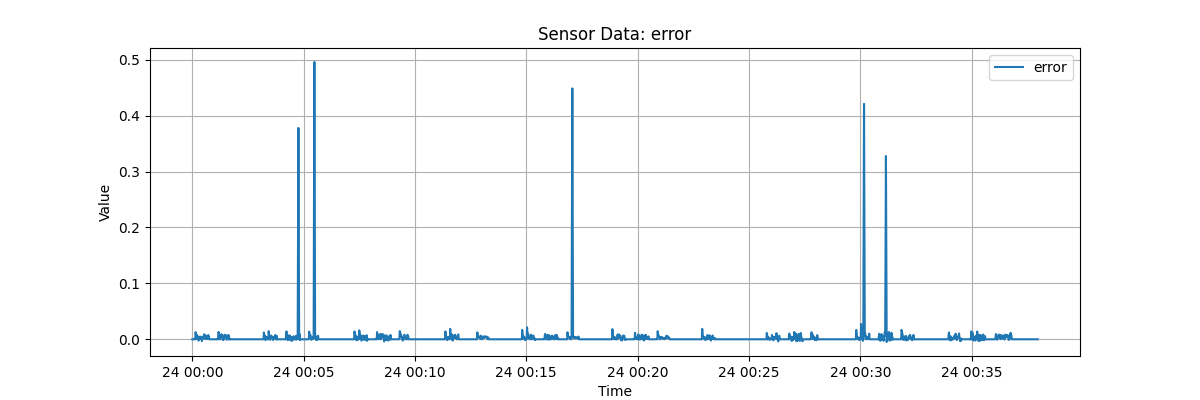

None


Observation: 시각화한 날짜: 2025-04-24
2025-04-24의 error 그래프를 시각화했습니다.
그래프를 확인했으니, 관련된 에러 패턴이나 조치가 궁금하시면 질문해 주세요.
Thought:이제 2025-04-24의 에러 그래프가 있으므로, 해당 날짜의 에러 패턴을 쿼리할 수 있습니다.
Action: QueryAnomalyHistory
Action Input: 2025-04-24의 에러 패턴은 무엇인가?[DEBUG] Available Columns: Index(['start_time', 'end_time', 'cmk', 'threshold', 'pattern_name'], dtype='object')

Observation: [아래는 이상 패턴 결과입니다. 요약하지 말고 그대로 출력하십시오.]
start_time: 2025-04-24 00:04:00, end_time: 2025-04-24 00:04:59, cmk: 1.06, threshold: 2.80, pattern_name: spike
start_time: 2025-04-24 00:05:00, end_time: 2025-04-24 00:05:59, cmk: 0.79, threshold: 2.80, pattern_name: spike
start_time: 2025-04-24 00:17:00, end_time: 2025-04-24 00:17:59, cmk: 0.88, threshold: 2.80, pattern_name: spike
start_time: 2025-04-24 00:30:00, end_time: 2025-04-24 00:30:59, cmk: 0.94, threshold: 2.80, pattern_name: spike
start_time: 2025-04-24 00:31:00, end_time: 2025-04-24 00:31:59, cmk: 1.22, threshold: 2.80, pattern_name: spike
Thought:이제 2025-04-24의 에러 패턴을 알았습니다.

'2025-04-24의 에러 패턴은 다음과 같습니다.\nstart_time: 2025-04-24 00:04:00, end_time: 2025-04-24 00:04:59, cmk: 1.06, threshold: 2.80, pattern_name: spike\nstart_time: 2025-04-24 00:05:00, end_time: 2025-04-24 00:05:59, cmk: 0.79, threshold: 2.80, pattern_name: spike\nstart_time: 2025-04-24 00:17:00, end_time: 2025-04-24 00:17:59, cmk: 0.88, threshold: 2.80, pattern_name: spike\nstart_time: 2025-04-24 00:30:00, end_time: 2025-04-24 00:30:59, cmk: 0.94, threshold: 2.80, pattern_name: spike\nstart_time: 2025-04-24 00:31:00, end_time: 2025-04-24 00:31:59, cmk: 1.22, threshold: 2.80, pattern_name: spike'

In [174]:
agent.run("위 그래프의 에러 패턴은 무엇인가?")

In [175]:
agent.run("그러한 상황에서 각각의 조치는?")



> Entering new AgentExecutor chain...
이 질문은 이전에 감지된 이상 상황에 대한 조치를 묻는 것이므로, `RecommendActions` 도구를 사용해야 합니다.

Action: RecommendActions
Action Input: 이전에 감지된 여러 이상 정보에 대한 조치
Observation: 📌 2025-04-24 00:04:00 ~ 2025-04-24 00:04:59: 패턴=spike, cmk=1.0550982152564596, threshold=2.8
➡ spike 패턴 감지 시, cmk 값에 따라 다음과 같은 조치를 취합니다:

*   **cmk 값이 0.8 이상 1.0 이하:** 공정 운전 유지, 주기적 측정 강화 및 팀장 보고 또는 일시적 오류로 판단하여 별도 조치 없이 모니터링 강화
*   **cmk 값이 0.8 이하:** 해당 설비의 순간 부하 또는 외부 간섭 의심, 주요 케이블 연결 상태 점검 및 데이터 필터링 적용

📌 2025-04-24 00:05:00 ~ 2025-04-24 00:05:59: 패턴=spike, cmk=0.7862113356983401, threshold=2.8
➡ 제공된 정보에 따르면:

*   **cmk 값이 0.8 이상 1.0 이하의 spike 이상:** 공정 운전 유지, 주기적 측정 강화, 팀장 보고 또는 일시적 오류로 판단 후 모니터링 강화.
*   **cmk 값이 0.8 이하의 spike 이상:** 설비의 순간 부하 또는 외부 간섭 의심, 케이블 연결 상태 점검 및 데이터 필터링 적용.

주어진 cmk 값들을 분석하면:

*   **1.06, 1.22:** 주어진 정보에 정확히 부합하는 조치는 없습니다. 다만, cmk 값이 1.0을 초과하는 spike에 대한 구체적인 조치 기준은 없으므로, 팀에 보고하여 적절한 조치를 결정하는 것이 좋습니다.
*   **0.79:** 케이블 연결 상태 점검 및 데이터 필터링을 적용합니다.
*   **0.88, 0.94:** 공정 운전 유지, 

'2025-04-24 00:04:00 ~ 2025-04-24 00:04:59 (cmk=1.0550982152564596): 공정 운전 유지, 주기적 측정 강화 및 팀장 보고 또는 일시적 오류로 판단하여 별도 조치 없이 모니터링 강화.\n2025-04-24 00:05:00 ~ 2025-04-24 00:05:59 (cmk=0.7862113356983401): 설비의 순간 부하 또는 외부 간섭 의심, 케이블 연결 상태 점검 및 데이터 필터링 적용.\n2025-04-24 00:17:00 ~ 2025-04-24 00:17:59 (cmk=0.8761632580304209): 공정 운전 유지, 주기적 측정 강화 및 팀장 보고 또는 일시적 오류로 판단하여 별도 조치 없이 모니터링 강화.\n2025-04-24 00:30:00 ~ 2025-04-24 00:30:59 (cmk=0.9352146808089332): 공정 운전 유지, 주기적 측정 강화 및 팀장 보고 또는 일시적 오류로 판단하여 별도 조치 없이 모니터링 강화.\n2025-04-24 00:31:00 ~ 2025-04-24 00:31:59 (cmk=1.2241977030293596): 주어진 정보에서는 spike 패턴에서 cmk 값이 0.8 이상 1.0 이하일 때의 조치만 나와 있습니다. 따라서 cmk=1.06일 때의 조치는 알 수 없습니다.'